In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)


from src.utils import MNIST, total_variation_loss_model, evaluate_loss_acc
from src.model import CNN, MLP
from src.utils import MNIST, evaluate_loss_acc


In [2]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp2"

# Гиперпараметры
alphas = np.arange(1e-4, 1e-3, 1e-4)

# Загрузка тестового набора
_, test_dataset, _, test_loader = MNIST()

# Функция потерь
criterion = torch.nn.CrossEntropyLoss()

# Определяем регуляризатор
regularizer = lambda model: total_variation_loss_model(model)

Alpha: 0.0001, TV Loss: 2187.984863, Test Accuracy: 0.95%, Test Loss: 0.157328


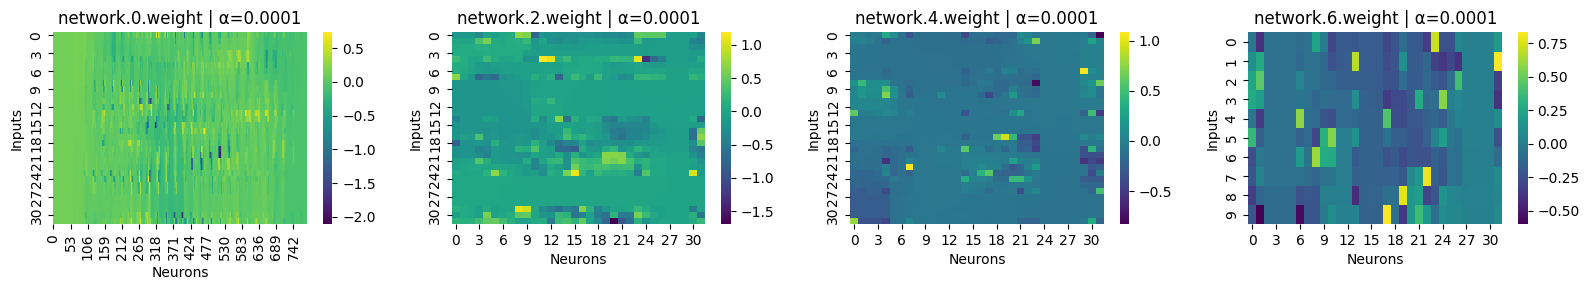

Alpha: 0.0002, TV Loss: 1436.433716, Test Accuracy: 0.91%, Test Loss: 0.308831


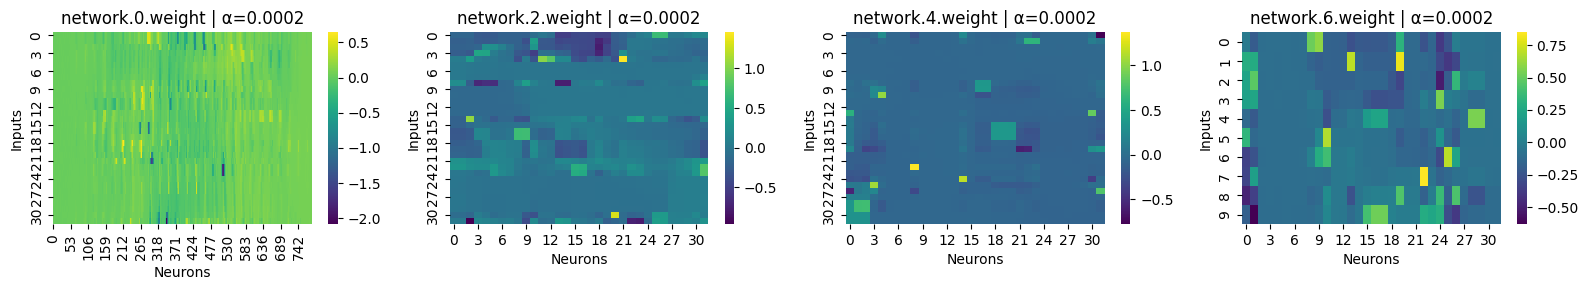

Alpha: 0.00030000000000000003, TV Loss: 1096.962769, Test Accuracy: 0.92%, Test Loss: 0.259292


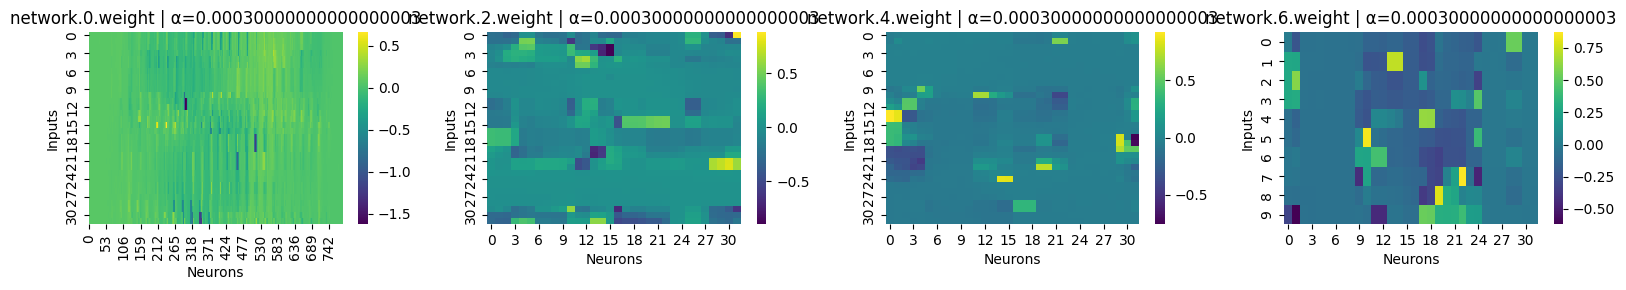

Alpha: 0.0004, TV Loss: 954.141663, Test Accuracy: 0.88%, Test Loss: 0.397627


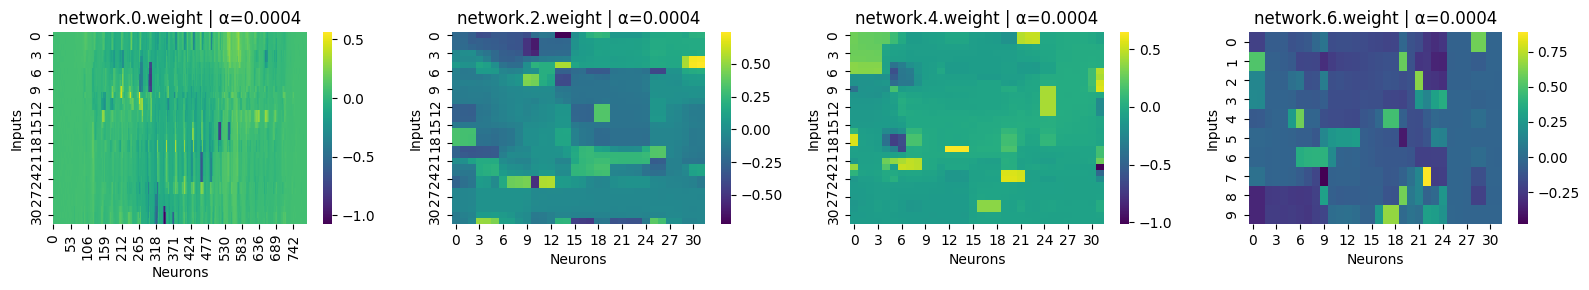

Alpha: 0.0005, TV Loss: 770.295776, Test Accuracy: 0.91%, Test Loss: 0.306685


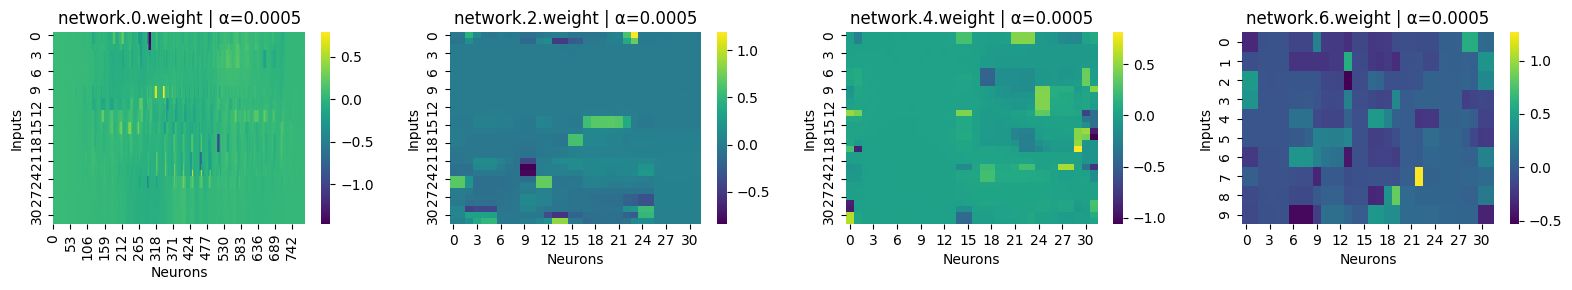

Alpha: 0.0006000000000000001, TV Loss: 685.941223, Test Accuracy: 0.91%, Test Loss: 0.296456


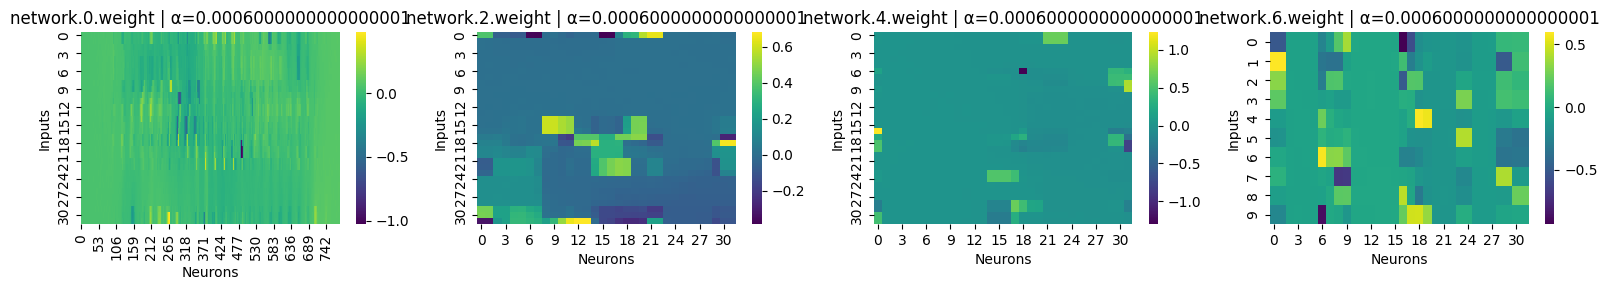

Alpha: 0.0007, TV Loss: 658.311096, Test Accuracy: 0.88%, Test Loss: 0.404963


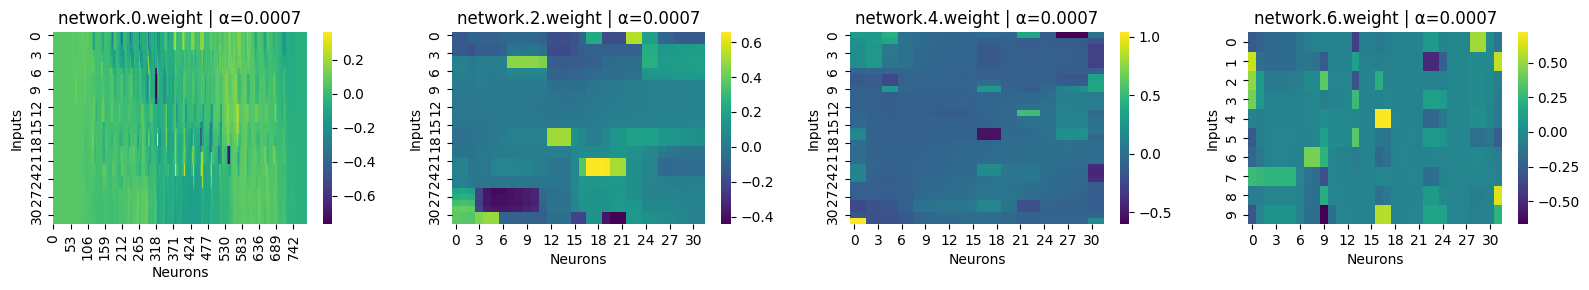

Alpha: 0.0008, TV Loss: 558.361694, Test Accuracy: 0.85%, Test Loss: 0.490255


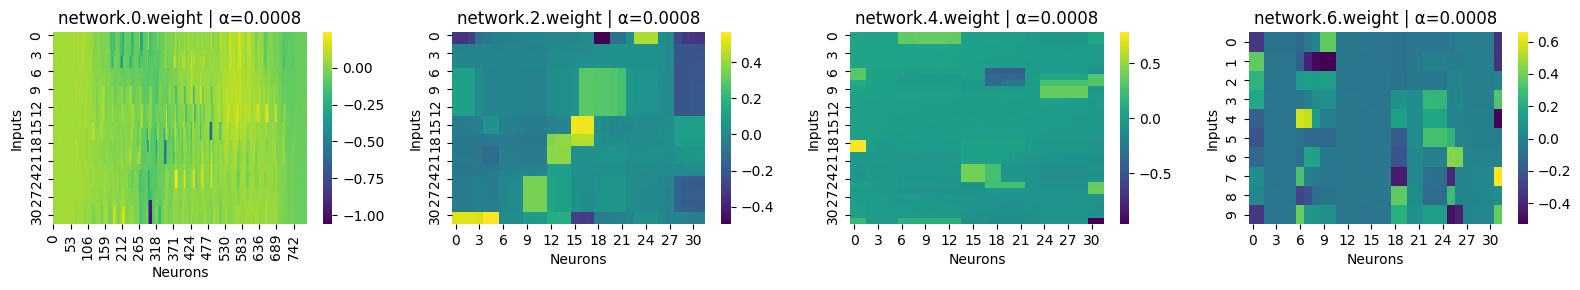

Alpha: 0.0009000000000000001, TV Loss: 517.708069, Test Accuracy: 0.87%, Test Loss: 0.413056


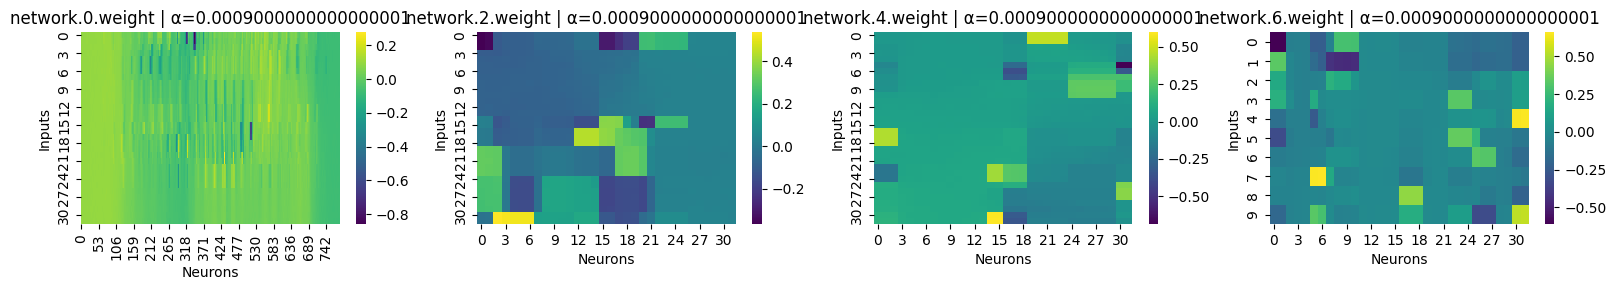

In [3]:

# Оценка моделей
results = []

for alpha in alphas:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_alpha_{alpha}.pth")

    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint {checkpoint_path} not found, skipping...")
        continue

    # Загружаем модель
    model = MLP().to(DEVICE)
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    model.eval()

    # Определяем регуляризатор
    regularizer = lambda model: total_variation_loss_model(model)

    # Оцениваем модель
    test_loss, test_acc, tv_loss = evaluate_loss_acc(test_loader, model, criterion, DEVICE, regularizer)

    # Сохраняем результаты
    results.append((alpha, tv_loss, test_acc, test_loss))
    print(f"Alpha: {alpha}, TV Loss: {tv_loss:.6f}, Test Accuracy: {test_acc:.2f}%, Test Loss: {test_loss:.6f}")

    # === 📊 Визуализация параметров через Heatmap ===
    param_list = []
    layer_names = []

    for name, param in model.named_parameters():
        if len(param.shape) == 2:  # Только матричные параметры
            param_data = param.cpu().detach().numpy()

            # if len(param.shape) == 4:  
            #     # 🛠 Обработка сверточных слоёв: (out_channels, in_channels, k, k) → (out_channels, in_channels * k * k)
            #     param_data = param_data.reshape(param.shape[0], -1)  

            param_list.append(param_data)
            layer_names.append(name)

    # Определяем размерность сетки
    num_layers = len(param_list)
    cols = min(4, num_layers)  # Максимум 4 колонки в строке
    rows = (num_layers + cols - 1) // cols  # Округляем вверх

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = np.array(axes).reshape(-1)  # Делаем массив 1D для удобства

    for i, (param_data, layer_name) in enumerate(zip(param_list, layer_names)):
        sns.heatmap(param_data, cmap="viridis", cbar=True, ax=axes[i])
        axes[i].set_title(f"{layer_name} | α={alpha}")
        axes[i].set_xlabel("Neurons")
        axes[i].set_ylabel("Inputs")

    # Убираем пустые графики
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [29]:
# Вывод итоговой таблицы
print("\n===== Results =====")
print(" Alpha    | TV Loss    | Test Accuracy | Test Loss")
print("---------------------------------------------------")
for alpha, tv_loss, test_acc, test_loss in results:
    print(f"{alpha:8} | {tv_loss:.6f} | {test_acc:.2f}%       | {test_loss:.6f}")



===== Results =====
 Alpha    | TV Loss    | Test Accuracy | Test Loss
---------------------------------------------------
  0.0001 | 4769.038574 | 0.98%       | 0.060722
  0.0002 | 3792.573975 | 0.97%       | 0.092261
0.00030000000000000003 | 3453.912842 | 0.97%       | 0.099878
  0.0004 | 4024.718994 | 0.97%       | 0.097164
  0.0005 | 3723.792725 | 0.97%       | 0.090966
0.0006000000000000001 | 3460.715332 | 0.98%       | 0.077207
  0.0007 | 3708.672119 | 0.98%       | 0.088117
  0.0008 | 3817.083496 | 0.97%       | 0.087519
0.0009000000000000001 | 3572.892578 | 0.98%       | 0.086640


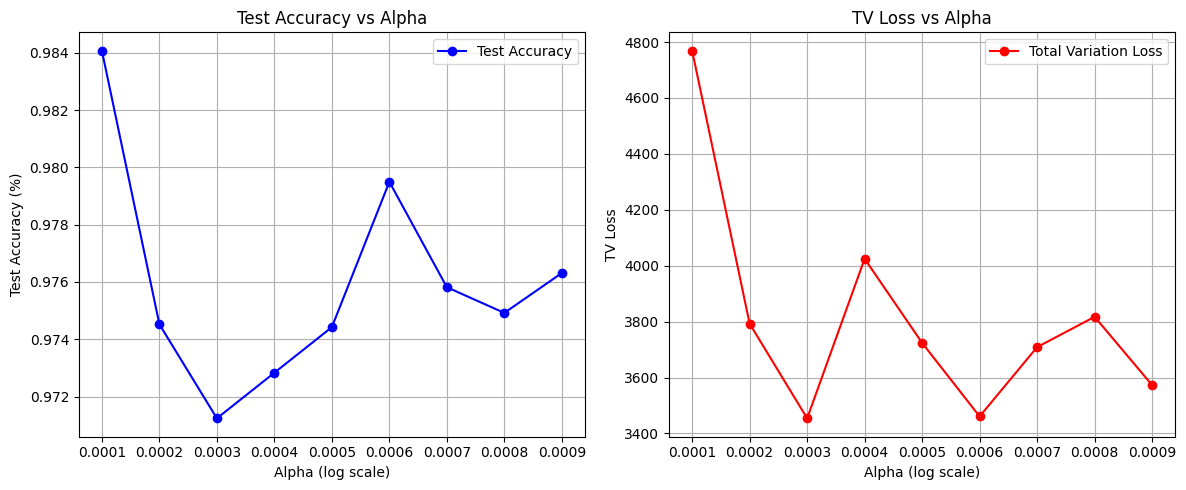

In [30]:
# Разбираем результаты для графиков
alphas_list, tv_losses, test_accuracies, test_losses = zip(*results)

# 📊 Визуализация
plt.figure(figsize=(12, 5))

# График 1: Test Accuracy vs Alpha
plt.subplot(1, 2, 1)
plt.plot(alphas_list, test_accuracies, marker='o', linestyle='-', color='b', label="Test Accuracy")
# plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy vs Alpha")
plt.legend()
plt.grid()

# График 2: TV Loss vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alphas_list, tv_losses, marker='o', linestyle='-', color='r', label="Total Variation Loss")
# plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("TV Loss")
plt.title("TV Loss vs Alpha")
plt.legend()
plt.grid()

# Показываем графики
plt.tight_layout()
plt.show()